<a href="https://colab.research.google.com/github/doudi25/Graph-machine-learning/blob/main/Copy_of_Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from gensim.models.word2vec import Word2Vec

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:

# Set random seed for reproducibility
np.random.seed(0)

# Generate an Erdős-Rényi random graph
# Parameters:
# - n: Number of nodes in the graph
# - p: Probability for edge creation between nodes
# - seed: Seed for random number generator (optional)
# - directed: Whether the graph is directed (default is False)
G = nx.erdos_renyi_graph(n=10, p=0.3, seed=1, directed=False)


In [ ]:
# the function help us to apply a bias walk to look like (BFS) or (DFS) instead of full randomness
def next_node(previous, current, p, q):
    # Get the neighbors of the current node
    neighbors = list(G.neighbors(current))
    alphas = []

    # Calculate transition probabilities based on parameters p and q
    for neighbor in neighbors:
        if neighbor == previous:  # If the neighbor is the previous node
            alpha = 1 / p
        elif G.has_edge(neighbor, previous):  # If there's an edge between neighbor and previous
            alpha = 1
        else:  # Otherwise
            alpha = 1 / q
        alphas.append(alpha)

    # Normalize the transition probabilities to get probabilities
    probs = [alph / sum(alphas) for alph in alphas]

    # Choose the next node based on the probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next


In [ ]:
def random_walk(start, length, next_node, p, q):
    walk = [start]  # Initialize the walk with the starting node
    for i in range(length):
        current = walk[-1]  # Get the current node
        previous = walk[-2] if len(walk) > 1 else None  # Get the previous node (if exists)
        next = next_node(previous, current, p, q)  # Determine the next node using next_node function
        walk.append(next)  # Add the next node to the walk
    return [str(x) for x in walk]  # Convert node IDs to strings and return the walk

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


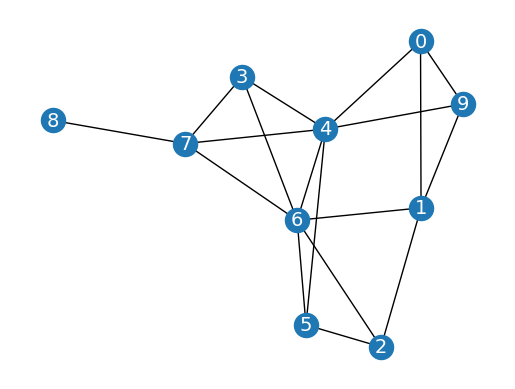

In [ ]:

# Create a new figure with specified DPI
plt.figure(dpi=100)

# Turn off the axis
plt.axis('off')

# Draw the graph
nx.draw_networkx(
    G,  # The graph to be drawn
    pos=nx.spring_layout(G, seed=0),  # Position nodes using spring layout algorithm
    node_size=300,  # Size of nodes
    cmap='coolwarm',  # Colormap for node colors
    font_size=14,  # Font size for node labels
    font_color='white'  # Font color for node labels
)

# Display the plot
plt.show()


In [ ]:
random_walk(0,10,next_node,p=10,q=2)

['0', '4', '6', '5', '2', '1', '6', '2', '1', '9', '1']

In [ ]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
G = nx.karate_club_graph()

In [ ]:
labels = []  # Initialize an empty list to store node labels

# Iterate over each node in the graph
for node in G.nodes:
    # Retrieve the club membership attribute for the current node
    label = G.nodes[node]['club']

    # Assign label 1 if the club membership is 'Officer', otherwise assign 0
    labels.append(1 if label == 'Officer' else 0)


In [ ]:
walks = []  # Initialize an empty list to store random walks

# Iterate over each node in the graph
for node in G.nodes:
    # Generate random walks starting from the current node
    for _ in range(80):  # Perform 80 random walks for each node
        walks.append(random_walk(node, 10, next_node, 3, 2))
# You can think as we want to build extract sentences from a text

In [ ]:
print(len(walks))

2720


In [ ]:
# Initialize Word2Vec model with parameters
node2vec = Word2Vec(
    walks,  # List of random walks
    hs=1,  # Hierarchical softmax
    sg=1,  # Skip-gram
    vector_size=100,  # Dimensionality of the word vectors
    window=10,  # Maximum distance between the current and predicted word within a sentence
    workers=2,  # Number of worker threads to train the model
    min_count=1,  # Ignores all words with total frequency lower than this
    seed=0,  # Seed for the random number generator
    negative=0  # Disable negative sampling
)


In [ ]:
# train the model in order to get the embedded represantation of nodes , nodes that often appear together are more likely to be presented in similar way
node2vec.train(walks,total_examples=node2vec.corpus_count,epochs=30,report_delay=1)


(185334, 897600)

In [ ]:
# Indices of nodes for training data
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
# Convert indices to string format
train_mask_str = [str(x) for x in train_mask]

# Indices of nodes for testing data
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
# Convert indices to string format
test_mask_str = [str(x) for x in test_mask]

# Convert labels list to NumPy array
labels = np.array(labels)


In [ ]:

# Initialize Support vector classifier model with regularization parameter C=2.0
clf = SVC(C=0.8)

# Train the SVC model using the Word2Vec embeddings of training nodes and their labels
clf.fit(node2vec.wv[train_mask_str], labels[train_mask])


SVC(C=0.8)

In [ ]:

# Predict labels for test nodes using the trained SVC model and Word2Vec embeddings
y_pred = clf.predict(node2vec.wv[test_mask_str])

# Calculate accuracy score by comparing predicted labels with actual labels for test nodes
acc = accuracy_score(y_pred, labels[test_mask])

# Print the accuracy score
print(f'Node2Vec accuracy = {acc * 100:.2f}%')
# Feel free to use another classification method such as RandomForest or DecesionTree to get better result


Node2Vec accuracy = 100.00%
